# LSTM for new type of datasets

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

import pandas as pd
import numpy as np

import plotly.express as px
from torch.optim import Adam


import matplotlib.pyplot as plt

## Classes

In [97]:
# class SequentDataset(Dataset):
#     def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
#         self.n_dot_parameters = n_dot_parameters
#         self.n_dots = n_dots
#         self.X_, self.y_ = self.__make_stack(dataframe)
#         # print(self.X_.shape)
#         # print(self.y_.shape)

#     def __len__(self):
#         return len(self.X_)

#     def __getitem__(self, idx):
#         return self.X_[idx], self.y_[idx]

#     def __make_stack(self, df: pd.DataFrame):
#         seq_amount = df.shape[0] - 2 * self.n_dots - 1
#         X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         for i in range(seq_amount):
#             X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
#             y[i, :, :] = torch.reshape(torch.tensor(df.values[i+1:i+1+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))

#         # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
#         return (X, y)

In [2]:
# sts
class SequentDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
        self.n_dot_parameters = n_dot_parameters
        self.n_dots = n_dots
        self.X_, self.y_ = self.__make_stack(dataframe)
        # print(self.X_.shape)
        # print(self.y_.shape)

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

    def __make_stack(self, df: pd.DataFrame):
        seq_amount = df.shape[0] - 2 * self.n_dots - 1
        X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        for i in range(seq_amount):  
            X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            y[i, :, :] = torch.reshape(torch.tensor(df.values[i+self.n_dots : i+2*self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            

        # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
        return (X, y)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=4, num_layers=10):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # x = x.to(device)
        batch_size = x.size(0)
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        # self.h = self.h.to(device)
        self.c = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        # self.c = self.c.to(device)
        out, _ = self.lstm(x, (self.h, self.c))

        # print(out.size())

        # Pass through fully connected layer
        out = self.linear(out)  # We want the output corresponding to the last time step
        return out

In [4]:
N_DOTS = 25
BATCH_SIZE = 8
N_DOT_PARAMETERS = 4
N_LSTM_LAYERS = 1

In [5]:
trajectory_train = pd.read_csv("../../sets_for_article/dash_slope_train.csv")
trajectory_test = pd.read_csv("../../sets_for_article/dash_slope_test.csv")

trajectory_train['t'] = 1
trajectory_test['t'] = 1

In [6]:
fig = px.line_3d(trajectory_train, x="X", y="Y", z="Z", color='I')
fig.show()

In [14]:
train = SequentDataset(trajectory_train[['t','X','Y','Z']][:8000], N_DOTS, 4)
test = SequentDataset(trajectory_train[['t','X','Y','Z']][8000:], N_DOTS, 4)
test2 = SequentDataset(trajectory_test[['t','X','Y','Z']], N_DOTS, 4)

In [8]:
model = LSTMModel(input_size=N_DOT_PARAMETERS, num_layers=N_LSTM_LAYERS)
# loss_model = nn.L1Loss()
loss_model = nn.HuberLoss()
# loss_model = nn.MSELoss()
# opt = Adam(model.parameters(), lr=0.005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

In [9]:
opt = Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=25, gamma=0.5)

In [ ]:
# model.load_state_dict(torch.load("lstm_dach_31_10.pt"))

C:\Users\Valiu\AppData\Local\Temp\ipykernel_20352\2175983290.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

In [107]:
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    return sum(train_loss)/len(train_loss)

In [108]:
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
    return sum(val_loss)/len(val_loss)

In [109]:
EPOCH = 150
train_losses = []
val_losses = []

train_data, val_data = random_split(train,[0.8,0.2])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

for epoch in range(EPOCH):

    mean_train_loss = train_model(model, loss_model, opt, train_loader, "cpu")

    train_losses.append(mean_train_loss)

    mean_val_loss = evaluate_model(model, loss_model, val_loader, "cpu")

    val_losses.append(mean_val_loss)

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()

    print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.6f}, val_loss = {mean_val_loss:.6f}, lr = {lr}")

Epoch [1/150], train_loss = 4.791165, val_loss = 2.532721, lr = [0.0001]
Epoch [2/150], train_loss = 1.548225, val_loss = 0.836864, lr = [0.0001]
Epoch [3/150], train_loss = 0.468915, val_loss = 0.230794, lr = [0.0001]
Epoch [4/150], train_loss = 0.128290, val_loss = 0.072344, lr = [0.0001]
Epoch [5/150], train_loss = 0.050441, val_loss = 0.040495, lr = [0.0001]
Epoch [6/150], train_loss = 0.034921, val_loss = 0.031801, lr = [0.0001]
Epoch [7/150], train_loss = 0.028533, val_loss = 0.026300, lr = [0.0001]
Epoch [8/150], train_loss = 0.023762, val_loss = 0.021770, lr = [0.0001]
Epoch [9/150], train_loss = 0.019560, val_loss = 0.017469, lr = [0.0001]
Epoch [10/150], train_loss = 0.015555, val_loss = 0.013705, lr = [0.0001]
Epoch [11/150], train_loss = 0.012278, val_loss = 0.010506, lr = [0.0001]
Epoch [12/150], train_loss = 0.009221, val_loss = 0.007949, lr = [0.0001]
Epoch [13/150], train_loss = 0.006885, val_loss = 0.005914, lr = [0.0001]
Epoch [14/150], train_loss = 0.004967, val_loss

In [ ]:
# torch.save(model.state_dict(),"lstm_dach_31_10.pt")

<function matplotlib.pyplot.show(close=None, block=None)>

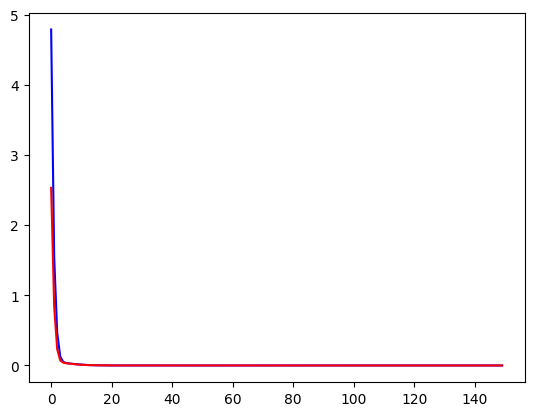

In [111]:
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.show

In [112]:
# predictions = []
# true = []

# start, _ = test[0]
# start = torch.reshape(start, (1,N_DOTS,N_DOT_PARAMETERS))

# for i in range(1000):
#     with torch.no_grad():
#         pred = model(start)
#         predictions.append(pred[0, -1, :])
#         start[0, :-1, :] = start.clone()[0, 1:, :]
#         start[0, -1, :] = pred[0, -1, :]
#         # start = pred
# _, y_true  = test[:1000]
# _, last = train[:]

In [15]:
# sts
predictions = []
true = []

start, _ = test2[0]
start = torch.reshape(start, (1,N_DOTS,N_DOT_PARAMETERS))

for i in range(1000):
    with torch.no_grad():
        pred = model(start)
        predictions.append(pred[0, -1, :])
        start = pred
        # start = pred
_, y_true  = test2[:1000]
_, last = train[:]

In [16]:
pred_data = pd.DataFrame([[0,0,0,0,0]], columns=["Time", "X", "Y", "Z", "I"])

p_x = pd.DataFrame(np.vstack(list(map(lambda x: x.detach().numpy(), predictions))), columns=["Time", "X", "Y", "Z"])
p_x['I'] = "Predict"
_, y  = test2[:]
p_y = pd.DataFrame(y.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z"])
p_y['I'] = "True"
p_last = pd.DataFrame(last.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z"])
p_last["I"] = "Last"

pred_data = pd.concat([pred_data,p_x,p_y,p_last],axis=0)


aaaab = pred_data.drop(pred_data.index[0], inplace=False)


In [17]:
fig = px.line_3d(aaaab, x="X", y="Y", z="Z", color='I',markers=True)
fig.show()